<a href="https://colab.research.google.com/github/Untick/InspectrumClinic_RecSys/blob/main/AndreySusarev/Profpatolog_parsing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Грузим библиотеки
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Activation
!pip install keras-tuner --upgrade
from tensorflow.keras import utils
from keras_tuner.tuners import Hyperband, BayesianOptimization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import statistics
import re
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import random
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from scipy import stats

%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 9.3 MB/s eta 0:00:00


In [ ]:
# Метрики для расчета ошибок
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.callbacks import ModelCheckpoint

In [ ]:
# и таблицу
# data = pd.read_excel('https://storage.yandexcloud.net/terratraineeship/23_InspectrumClinic_RS/datasets/%D0%B4%D0%B0%D1%82%D0%B0%D1%81%D0%B5%D1%82%20%D0%BF%D1%80%D0%BE%D1%84%D0%BF%D0%B0%D1%82%D0%BE%D0%BB%D0%BE%D0%B3%20%D1%87%D0%B0%D1%81%D1%82%D1%8C.xlsx')

In [ ]:
# Подключим диск
from google.colab import drive
drive.mount('/content/drive')

# и сохраним туда исходную таблицу
# data.to_excel('/content/drive/MyDrive/Стажировка/Profpatolog/Data/data_2.xlsx')

Mounted at /content/drive


In [ ]:
data = pd.read_excel('/content/drive/MyDrive/Стажировка/Profpatolog/Data/data_2.xlsx')

In [ ]:
# Смотрим структуру
print(data.shape)
print(data.info())
# print(data.head())
data.describe()

In [ ]:
# Вычислим возраст клиентов, результат запишим в отдельную колонку

data['Возраст'] = (data['ДатаЗавершенияМедосмотра'] - data['КлиентДатаРождения']).dt.days // 365

In [ ]:
# Посмотрим...
display(data.head())
data[['КлиентДатаРождения', 'ДатаЗавершенияМедосмотра', 'Возраст']].head()

In [ ]:
# Cоздаем список с искомыми словами в названиях столбцов для последующего удаления
excluded_words = ['Представление', 'Документ', 'Контрагент', 'Врач', 'ЗаключениеМК', 'Салон', 'Дата']

# Формируем новую таблицу, удаляя столбцы из созданного списка
new_columns = [col for col in df_cut.columns if not any(word in col for word in excluded_words)]
new_df = data[new_columns]
new_df.info()

# Также удалим столбцы "Клиент", "Unnamed: 0"
new_df=new_df.drop(columns=['Клиент', 'Unnamed: 0'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1982 entries, 0 to 1981
Columns: 921 entries, Unnamed: 0 to Возраст
dtypes: float64(138), int64(2), object(781)
memory usage: 13.9+ MB


In [ ]:
df_cut = new_df.drop(new_df.select_dtypes(include=['bool']), axis=1)                                    # удаляем колонки с типом bool
df_cut = df_cut.loc[:, df_cut.isnull().mean() < 0.99]                                                   # удаляем "почти" пустые колонки
col_list = df_cut.columns.tolist()                                                                      # список столбцов
df_cut[col_list] = df_cut[col_list].astype(str).apply(lambda x: x.str.replace(r'\W+', '', regex=True))  # удаление служебных символов из столбцов
df_cut = df_cut.applymap(lambda x: x.lower() if type(x) == str else x)                                  # заменяем все заглавные буквы на прописные

In [ ]:
print(df_cut.info())
df_cut.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1982 entries, 0 to 1981
Columns: 919 entries, КлиентПол to Возраст
dtypes: object(919)
memory usage: 13.9+ MB
None


,КлиентПол,ТипМедосмотра,Цех,Профессия,Заключение,ДиспансернаяГруппа,ВредныеФакторы,ЛабораторныеИсследования1_Специализация,ЛабораторныеИсследования1_ОАК_Значение,ЛабораторныеИсследования1_Биохимия_Значение,...,Психиатрия2_Диагноз_Значение,Психиатрия2_БезСледовВВИнъекций_Значение,Психиатрия2_БезСледовСамопорезов_Значение,Психиатрия2_МышлениеКонкретное_Значение,Психиатрия2_ПсихическаяАктивность_Значение,Психиатрия2_ПсихическаяАктивность2_Значение,Психиатрия2_МышлениеВ_Значение,Психиатрия2_Интеллект_Значение,Психиатрия2_ДанныхЗаНаркологическуюПатологиюНаМоментОсмотра_Значение,Возраст
0,женский,периодический,nan,ведущийспециалистпоорганизацииобуения,годенкработевуказанныхусловиях,i,114,e866ea50093d11e287b2002618dcef2c,получен,получен,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,45
1,мужской,периодический,nan,ведущийспециалист,годенкработевуказанныхусловиях,iiiа,425,e866ea50093d11e287b2002618dcef2c,получен,получен,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,34
2,мужской,периодический,nan,главныйменеджер,годенкработевуказанныхусловияхскоррекциейзрения,ii,425,e866ea50093d11e287b2002618dcef2c,получен,получен,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,36
3,мужской,периодический,отделтехникиитехнологиистроительстваскважин,главныйспециалист,годенкработевуказанныхусловиях,i,111,e866ea50093d11e287b2002618dcef2c,получен,получен,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,33
4,мужской,периодический,отделтехнологийтекущегоикапитальногоремонтаскв...,старшийспециалист,годенкработевуказанныхусловияхскоррекциейзрения,ii,111,e866ea50093d11e287b2002618dcef2c,получен,получен,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,37


In [ ]:
df_cut.describe()

,КлиентПол,ТипМедосмотра,Цех,Профессия,Заключение,ДиспансернаяГруппа,ВредныеФакторы,ЛабораторныеИсследования1_Специализация,ЛабораторныеИсследования1_ОАК_Значение,ЛабораторныеИсследования1_Биохимия_Значение,...,Психиатрия2_Диагноз_Значение,Психиатрия2_БезСледовВВИнъекций_Значение,Психиатрия2_БезСледовСамопорезов_Значение,Психиатрия2_МышлениеКонкретное_Значение,Психиатрия2_ПсихическаяАктивность_Значение,Психиатрия2_ПсихическаяАктивность2_Значение,Психиатрия2_МышлениеВ_Значение,Психиатрия2_Интеллект_Значение,Психиатрия2_ДанныхЗаНаркологическуюПатологиюНаМоментОсмотра_Значение,Возраст
count,1982,1982,1982,1982,1982,1982,1982,1982,1982,1982,...,1982,1982,1982,1982,1982,1982,1982,1982,1982,1982
unique,2,2,182,588,13,8,514,4,2,2,...,2,2,2,2,2,2,2,2,2,54
top,мужской,периодический,nan,водитель,годенкработевуказанныхусловиях,i,23,e866ea50093d11e287b2002618dcef2c,получен,получен,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,36
freq,1451,1981,1180,64,1424,779,227,1652,1652,1655,...,1960,1960,1960,1960,1960,1960,1960,1960,1960,83


In [ ]:
# Создадим словарь категориальных признаков "new_df"
dicts = {}
for i in df_cut.columns.values.tolist():
    if df_cut[i].dtypes == object:
        c = 0
        dl = {}
        for j in df_cut[i].unique():
            c += 1
            dl.update({j:c})
        dicts.update({i:dl})
# dict      
    

In [ ]:
# Соберем таблицу категориальных признаков на базе "df_cut" и "dicts"
df_fl = df_cut.copy()
for i in dicts.keys():
    for j in range(df_cut[i].shape[0]):
        df_fl[i][j] = float(dicts.get(i).get(df_cut[i][j]))

In [ ]:
# Преобразуем в тип float
df_fl = df_fl.astype(float)
# df_fl

In [ ]:
df_fl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1982 entries, 0 to 1981
Columns: 919 entries, КлиентПол to Возраст
dtypes: float64(919)
memory usage: 13.9 MB


In [ ]:
# Нормализуем данные в таблице признаков (кроме "Заключение")
for i in df_fl.columns.values.tolist():
   if i != 'Заключение':
        df_fl[i] = df_fl[i]/df_fl[i].max()

In [ ]:
# Сформируем массив данных и их значений
x=df_fl.drop(columns=['Заключение']).reset_index(drop=True)
y=df_fl['Заключение']
# x, y

In [ ]:
# Пример обработанных данных
y = np.expand_dims(y, axis=1)
print(x.shape)
print(y.shape)

(1982, 918)
(1982,)


In [ ]:
y.head()

0    1.0
1    1.0
2    2.0
3    1.0
4    2.0
Name: Заключение, dtype: float64

In [ ]:
# Разобъем массив на обучающую и тестовую выборки
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle = True)

In [ ]:
# вывод размеров обучающей и проверочной выборок
print(f'Размер обучающей выборки: {x_train.shape[0]}')
print(f'Размер проверочной выборки: {x_test.shape[0]}')

Размер обучающей выборки: 1585
Размер проверочной выборки: 397


## Визуализация

In [ ]:
# Получение списка значений разницы между y_test и pred
def test_pred_diff_plot(test, pred, method):
    l_dl = []
    print(method)
    for i in range(0, len(test)):
#       print(test[i], pred[i], sep=' ')
        dif = (abs(test[i]-pred[i])/test[i])*100
        if dif != float("inf"):
           l_dl.append(dif)
    return l_dl

In [ ]:
def ml_method_est(method_list,  x_train, x_test, y_train, y_test, plot=False):

    y_train=np.reshape(y_train.values, (-1,1))
    y_test=np.reshape(y_test.values, (-1,1))

    methods = []
    MAE_list = []
    R_2_list = []
    MSE_list = []
    diff_list = []
    valscore_list = []
    plots = []
    for i in method_list:
        model = i.fit(x_train, y_train)
        p1 = model.predict(x_test)

        mae = mean_absolute_error(y_test, p1)
        r2 = r2_score(y_test, p1)
        mse = mean_squared_error(y_test, p1)

        fold = KFold(n_splits = 6, shuffle = True, random_state = 5)
        scores = cross_val_score(estimator = model, X = x_train, y = y_train, cv=fold)

        methods.append(str(i))
        MAE_list.append(mae)
        R_2_list.append(r2)
        MSE_list.append(mse)
        valscore_list.append(scores.mean())

        diff = test_pred_diff_plot(y_test, p1, i)
        plots.append(diff)
        diff_list.append(sum(diff)/len(y_test))

    method_col=pd.Series(methods)
    mae_col = pd.Series(MAE_list)
    r_2_col = pd.Series(R_2_list)
    mse_col = pd.Series(MSE_list)
    valscore_col = pd.Series(valscore_list)
    est_df = pd.DataFrame({'method':method_col, 'mae':mae_col, 'r_2':r_2_col, 'mse':mse_col, 'mean_diff(%)':diff_list, 'mean_val_score':valscore_col})

    count=0
    for k in plots:
        plt.plot(k, label=str(count))
        count += 1
    plt.legend()
    plt.title('Величина различий реальных и предсказанных значений в % в зависимости от методики')
    plt.show()


    return est_df


## Предобученные алгоритмы ML

In [ ]:
# Библиотеки с алгоритмами ML и функциями ошибки
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xg
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

GradientBoostingRegressor()
RandomForestRegressor(max_depth=3, random_state=0)
[21:17:46] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[21:17:46] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[21:17:48] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[21:17:49] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[21:17:49] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[21:17:50] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[21:17:50] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylev

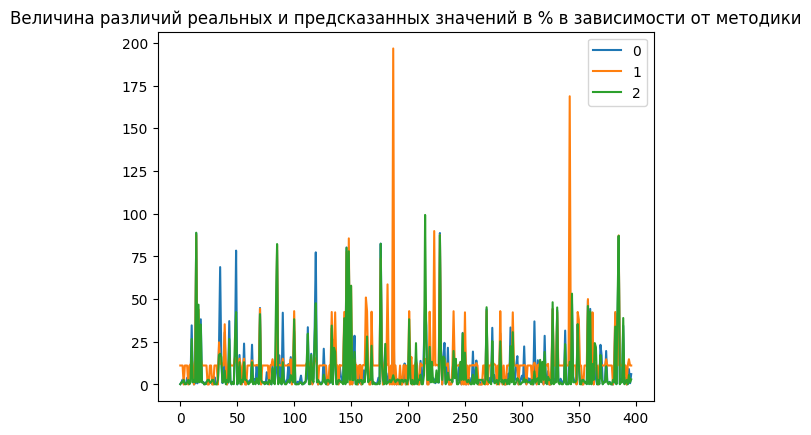

,method,mae,r_2,mse,mean_diff(%),mean_val_score
0,GradientBoostingRegressor(),0.212064,0.922101,0.790085,[8.754822407516908],0.955474
1,"RandomForestRegressor(max_depth=3, random_stat...",0.271924,0.915712,0.854882,[13.923821758294645],0.952977
2,"XGBRegressor(base_score=None, booster=None, ca...",0.238759,0.920613,0.805174,[7.642021543700059],0.951728


In [ ]:
# Используем три алгоритма ML:
l=[GradientBoostingRegressor(), RandomForestRegressor(max_depth=3, random_state=0), xg.XGBRegressor(objective ='reg:linear', n_estimators = 10, seed = 123)]
ml_method_est(l, x_train, x_test, y_train, y_test, plot=True)

In [ ]:
def dl_method_estim(dl_method_list, x_dl_train, x_dl_test, y_dl_train,  y_dl_test):

    y_dl_test =np.reshape(y_dl_test.values,(-1,1))
    y_dl_train =np.reshape(y_dl_train.values,(-1,1))
    plots=[]
    cols={}

    
    for i in dl_method_list:
        
        history=i.fit(x_dl_train, y_dl_train, epochs=60, batch_size=4, validation_split=0.1, verbose=1)
        plt.plot(history.history['accuracy'],
                 label='Точность на обучающем наборе')           # Отрисовка графика обучения
        plt.plot(history.history['val_accuracy'],
                 label='Точность на проверочном наборе')
        plt.xlabel('Эпоха обучения')
        plt.ylabel('Точность')
        plt.legend()
        plt.show()

        pred=i.predict(x_dl_test)

        # График отношения реальных (test) и предсказанных(pred) значений. При текущем объеме выборки наверно малоинформативен.
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.scatter(y_dl_test, pred)
        ax.plot(plt.xlim(), plt.ylim(), 'r')
        plt.xlabel('test')
        plt.ylabel('pred')
        plt.grid()
        plt.title('Соотношение реальных и предсказанных значений')
        plt.show()

        plots.append(test_pred_diff_plot(y_dl_test, pred, i))
    count=0
    # Сравнение различий реальных и предсказанных между разными архитектурами сетей
    for k in plots:
        plt.plot(k, label=str(count))
        cols[str(count)]=k
        count+=1
    plt.legend()
    plt.title('Величина различий реальных и предсказанных значений в % в зависимости от архитектуры сети')
    plt.show()
    print('Среднее значение %-та различий реальных и предсказанных значений: model_1: {:.3f}, model_2: {:.3f}'.format(float(sum(cols['0'])/len(cols['0'])), float(sum(cols['1'])/len(cols['1']))))
    # dl_table=pd.DataFrame(cols)
    return pd.DataFrame(cols)

In [ ]:
def get_dl_list(input_dim):
    dl_method_list=[]
    dl_model_1=Sequential()
    dl_model_1.add(Dense(1000, input_dim=input_dim, activation='relu'))
    dl_model_1.add(Dense(500, activation='tanh'))
    dl_model_1.add(Dense(1, activation='linear'))
    dl_model_1.compile(loss='mse', optimizer=Adam(learning_rate=1e-5), metrics=['accuracy', 'mape'])
    dl_model_1.summary()
    model_2 = Sequential()
    model_2.add(Dense(500,activation='relu', input_dim=input_dim))
    model_2.add(Dense(200, activation='tanh'))
    model_2.add(Dense(100, activation='relu'))
    model_2.add(Dense(1, activation='linear'))
    model_2.compile(optimizer= Adam(learning_rate=1e-5), loss='mse', metrics=['accuracy', 'mape'])
    model_2.summary()
    dl_method_list.append(dl_model_1)
    dl_method_list.append(model_2)
    return dl_method_list

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_136 (Dense)           (None, 1000)              919000    
                                                                 
 dense_137 (Dense)           (None, 500)               500500    
                                                                 
 dense_138 (Dense)           (None, 1)                 501       
                                                                 
Total params: 1,420,001
Trainable params: 1,420,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_139 (Dense)           (None, 500)               459500    
                                                                 
 dense_140 (Dense)  

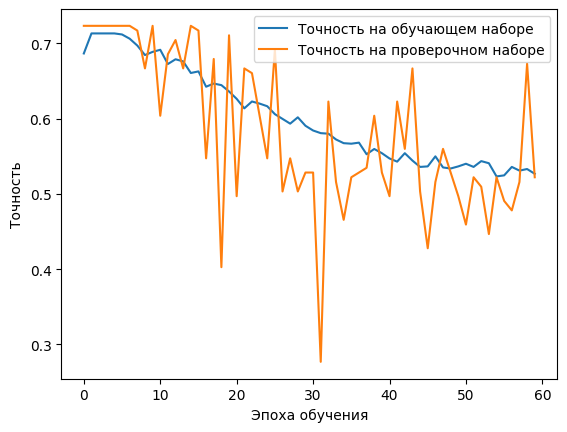

13/13 [==============================] - 0s 3ms/step


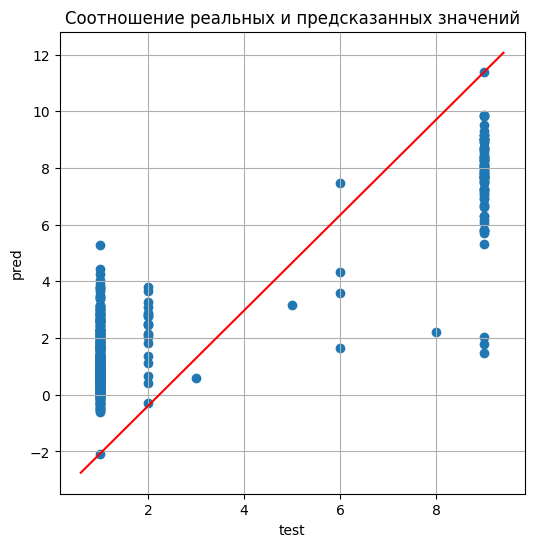

Epoch 1/60
357/357 [==============================] - 3s 6ms/step - loss: 11.2814 - accuracy: 0.6964 - mape: 127.5804 - val_loss: 10.8155 - val_accuracy: 0.7233 - val_mape: 138.9770
Epoch 2/60
357/357 [==============================] - 3s 7ms/step - loss: 10.3988 - accuracy: 0.7132 - mape: 140.0656 - val_loss: 10.2433 - val_accuracy: 0.7233 - val_mape: 151.3322
Epoch 3/60
357/357 [==============================] - 2s 5ms/step - loss: 10.0715 - accuracy: 0.7132 - mape: 141.1650 - val_loss: 9.9598 - val_accuracy: 0.7233 - val_mape: 112.6896
Epoch 4/60
357/357 [==============================] - 2s 5ms/step - loss: 9.7664 - accuracy: 0.7132 - mape: 134.7651 - val_loss: 9.3255 - val_accuracy: 0.7233 - val_mape: 144.9576
Epoch 5/60
357/357 [==============================] - 2s 4ms/step - loss: 9.4477 - accuracy: 0.7132 - mape: 135.6588 - val_loss: 8.9153 - val_accuracy: 0.7233 - val_mape: 129.8362
Epoch 6/60
357/357 [==============================] - 2s 5ms/step - loss: 9.1477 - accuracy: 0.

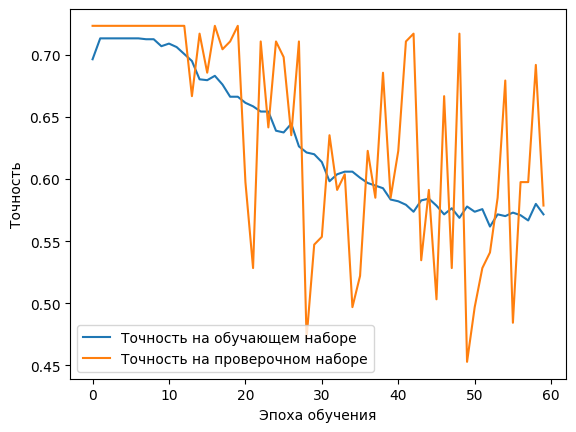

13/13 [==============================] - 0s 3ms/step


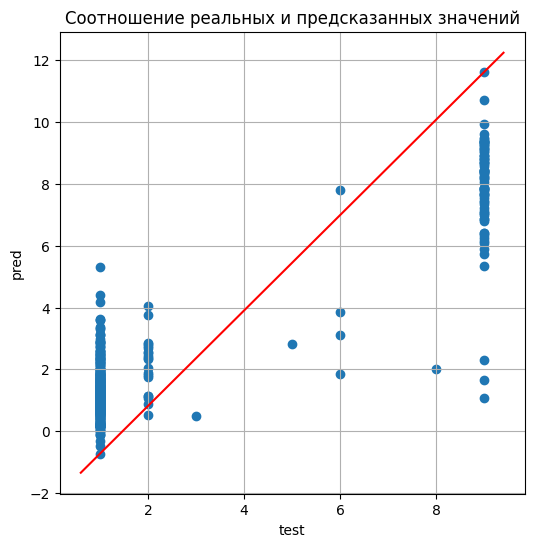

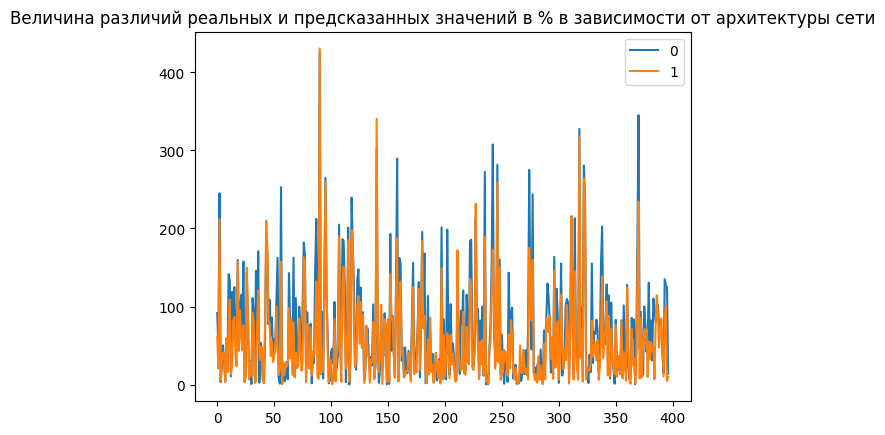

Среднее значение %-та различий реальных и предсказанных значений: model_1: 72.055, model_2: 56.378


,0,1
0,[91.58133268356323],[61.495327949523926]
1,[48.805367946624756],[20.61326503753662]
2,[245.13020515441895],[211.9849681854248]
3,[3.3182250128851996],[5.5811034308539496]
4,[20.244121551513672],[29.374587535858154]
...,...,...
392,[14.709716373019749],[10.585276285807293]
393,[134.92236137390137],[81.47577196359634]
394,[127.54287719726562],[100.89242458343506]
395,[124.62230920791626],[4.60963249206543]


In [ ]:
dl_method_estim(get_dl_list(918),x_train, x_test, y_train, y_test)

## Autokeras

In [ ]:
# Установим autokeras
!pip install autokeras
import autokeras as ak

In [ ]:
# инициализация класса автоматического машинного обучения
reg2 = ak.StructuredDataRegressor(
    overwrite=True,
    max_trials=10,
    tuner="hyperband",
    loss='mean_squared_error',
    metrics=['mean_absolute_error'],
    project_name='weekly_sales_forecast2'
)

# поиск лучшей модели
reg2.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))

In [ ]:
best_model2 = reg2.export_model()
best_model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 918)]             0         
                                                                 
 multi_category_encoding (Mu  (None, 918)              0         
 ltiCategoryEncoding)                                            
                                                                 
 normalization (Normalizatio  (None, 918)              1837      
 n)                                                              
                                                                 
 dense (Dense)               (None, 512)               470528    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                             

## Разное

In [ ]:
model = Sequential()
model.add(Dense(32, input_dim=10))
model.add(Dense(5))
model.add(Dense(1))

model.summary()

In [ ]:
model_2 = Sequential()
model_2.add(Dense(512,activation='relu', input_dim=918))
model_2.add(Dense(256, activation='relu'))
model_2.add(Dense(64, activation='relu'))
model_2.add(Dense(1, activation='linear'))
model_2.compile(optimizer= Adam(learning_rate=1e-5), loss='mse', metrics=['accuracy', 'mape'])
model_2.summary()

## Простая НС

In [ ]:
# Функция отрисовки графика истории обучения
def plot_history(history):
    plt.plot(history.history['mape'], 
            label='Средняя абсолютная ошибка на обучающем наборе')
    plt.plot(history.history['val_mape'], 
            label='Средняя абсолютная ошибка на проверочном наборе')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Средняя абсолютная ошибка')
    plt.legend()
    plt.show()

In [ ]:
# Сохраним лучшие веса
filepath="best_model_weights.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_mape', verbose=1, save_best_only=True, mode='min')

Epoch 1/80
6/7 [========================>.....] - ETA: 0s - loss: 10.6980 - mape: 98.6423
Epoch 1: val_mape did not improve from 33.21995
7/7 [==============================] - 2s 86ms/step - loss: 10.3763 - mape: 100.8691 - val_loss: 21.9880 - val_mape: 49.7220
Epoch 2/80
6/7 [========================>.....] - ETA: 0s - loss: 7.2475 - mape: 129.8031
Epoch 2: val_mape did not improve from 33.21995
7/7 [==============================] - 0s 65ms/step - loss: 7.2276 - mape: 129.6376 - val_loss: 22.8657 - val_mape: 62.7238
Epoch 3/80
6/7 [========================>.....] - ETA: 0s - loss: 5.7618 - mape: 123.5024
Epoch 3: val_mape did not improve from 33.21995
7/7 [==============================] - 0s 63ms/step - loss: 5.6389 - mape: 122.5776 - val_loss: 22.5495 - val_mape: 60.3429
Epoch 4/80
6/7 [========================>.....] - ETA: 0s - loss: 4.5803 - mape: 102.2031
Epoch 4: val_mape did not improve from 33.21995
7/7 [==============================] - 0s 61ms/step - loss: 4.5363 - mape: 

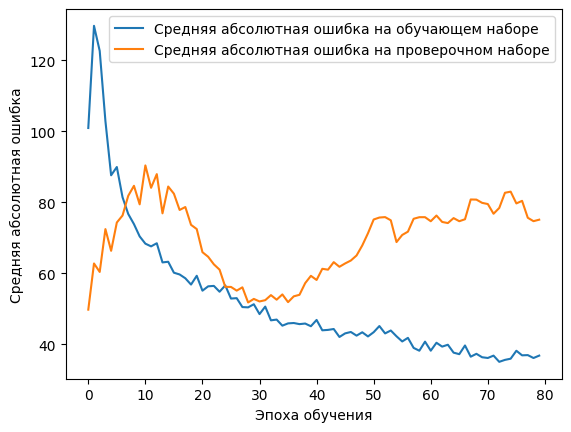

In [ ]:
# Модель

model_simple = Sequential()
model_simple.add(BatchNormalization(input_dim=x.shape[1]))
model_simple.add(Dense(918, activation='relu'))
model_simple.add(Dense(1000, activation='tanh'))
model_simple.add(BatchNormalization())
model_simple.add(Dropout(0.3))
model_simple.add(Dense(500, activation='relu'))
model_simple.add(Dense(1, activation='linear'))

model_simple.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mape'])

history = model_simple.fit(x, 
                    y, 
                    epochs=80, 
                    batch_size=256,
                    validation_split=0.15, 
                    verbose=1, callbacks=[checkpoint])

plot_history(history)

In [ ]:
# Загрузка лучших весов в модель для использования при проверке:

model_simple.load_weights('best_model_weights.h5')

In [ ]:
# Проверка работы сети - предсказание на тренировочной выборке
pred = model_simple.predict(x)

# Расчет среднего значения ошибки 
print((abs(pred - y)).mean())         # Расчет вручную
# print(mean_absolute_error(pred, y))   # Расчет с помощью готовой функции

62/62 [==============================] - 0s 4ms/step
0.5013097675242786


In [ ]:
# Функция оценки результатов и вывода оценки

def eval_net(model, x, y, y_scaler = None, n = 10, limit = 10.):
  
    pred = model.predict(x)             # Предсказание на тренировочной выборке
    if y_scaler:                              # Если есть нормирование - то денормировать
        pred = y_scaler.inverse_transform(pred)

    print('Средняя абсолютная ошибка:', mean_absolute_error(pred, y), '\n')

    for i in range(n):
        print('Реальное значение: {:6.2f}  Предсказанное значение: {:6.2f}  Разница: {:6.2f}'.format(y[i, 0],
                                                                                                    pred[i, 0],
                                                                                                    abs(y[i, 0] - pred[i, 0])))
    # Построение картинки разброса предсказанных и верных значений зарплаты
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(y, pred)                 # Отрисовка точечного графика
    ax.set_xlim(0, limit)                     # Пределы по x, y
    ax.set_ylim(0, limit)
    ax.plot(plt.xlim(), plt.ylim(), 'r')      # Отрисовка диагональной линии
    plt.xlabel('Правильные значения')
    plt.ylabel('Предсказания')
    plt.grid()
    plt.show()        

62/62 [==============================] - 0s 5ms/step
Средняя абсолютная ошибка: 0.28628795472933233 

Реальное значение:   1.00  Предсказанное значение:   1.00  Разница:   0.00
Реальное значение:   1.00  Предсказанное значение:   1.00  Разница:   0.00
Реальное значение:   2.00  Предсказанное значение:   2.48  Разница:   0.48
Реальное значение:   1.00  Предсказанное значение:   0.99  Разница:   0.01
Реальное значение:   2.00  Предсказанное значение:   2.06  Разница:   0.06
Реальное значение:   1.00  Предсказанное значение:   1.09  Разница:   0.09
Реальное значение:   2.00  Предсказанное значение:   2.00  Разница:   0.00
Реальное значение:   1.00  Предсказанное значение:   1.10  Разница:   0.10
Реальное значение:   1.00  Предсказанное значение:   1.05  Разница:   0.05
Реальное значение:   1.00  Предсказанное значение:   0.87  Разница:   0.13


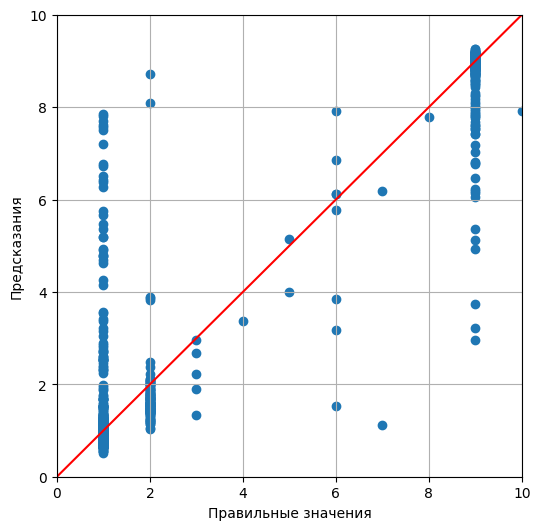

In [ ]:
eval_net(model_simple, x, y)